Como Atividade M2, sugiro você repetir a Atividade M1, porém agora partindo da Atividade 3 da IC/TCC (onde dados in e out são complexos e há dados de extração e validação).

Importante:

1.o retorno da function (ou define) agora deve ser o módulo do vetor de erro (na Atividade M1 era apenas o vetor de erro). Ou seja, o retorno é um vetor de números reais;

2. sobre os argumentos da function, há 2 possibilidades:

2a) (essa possibilidade com certeza funciona) passar argumentos que são números reais que representam as partes real e imaginária de cada coeficiente (ou seja, se há C coeficientes complexos, passar 2C valores reais como argumento da function). Dentro da function você monta os coeficientes complexos. Nesse caso, o argumento e retorno da function são reais e, mesmo que dentro da function haja processamento com números complexos, isso não é "visível" para o otimizador;

2b) (não tenha certeza se funciona) passar argumentos para a function que são números complexos indicando diretamente os coeficientes complexos. Aqui tenho dúvidas se o otimizador irá otimizar ambas partes real e imaginária dos coeficientes.

3. Ao realizar o transposto, como agora os números são complexos, usar .' ou trans().

In [4]:
from scipy.io import loadmat

mat = loadmat('in_out_SBRT2_direto.mat')

in_data_ext = mat['in_extraction'].flatten()
out_data_ext = mat['out_extraction'].flatten()
in_data_val = mat['in_validation'].flatten()
out_data_val = mat['out_validation'].flatten()


In [5]:
import numpy as np

def erro_mp_complex(params, x_in, y_out, ordem, memoria):
    """
    params : vetor real (2*C), partes real e imaginária dos coef complexos
    x_in   : entrada complexa
    y_out  : saída desejada complexa
    ordem  : ordem do polinômio
    memoria: número de atrasos
    """
    # Reconstituir coeficientes complexos
    C = len(params)//2
    coef = params[:C] + 1j*params[C:]

    N = len(x_in)
    y_est = np.zeros(N, dtype=complex)

    idx = 0
    for k in range(memoria+1):
        xk = np.roll(x_in, k)
        for p in range(1, ordem+1):
            y_est += coef[idx] * (xk * np.abs(xk)**((p-1)*2))
            idx += 1

    erro = y_out - y_est
    return np.abs(erro)   # retorno deve ser real (módulo do erro)


In [6]:
from scipy.optimize import least_squares

ordem = 3
memoria = 2
num_coef = ordem * (memoria+1)

# Vetor inicial: separar parte real e imaginária
x0 = np.zeros(2*num_coef)

res = least_squares(
    erro_mp_complex,
    x0,
    args=(in_data_ext, out_data_ext, ordem, memoria),
    verbose=2
)

coef_otimo = res.x[:num_coef] + 1j*res.x[num_coef:]
print("Coeficientes complexos otimizados:", coef_otimo)

# Calcular MSE na validação
erro_val = erro_mp_complex(res.x, in_data_val, out_data_val, ordem, memoria)
mse_val = np.mean(erro_val**2)
print("MSE validação:", mse_val)


   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         8.8318e+02                                    2.03e+03    
       1              2         6.2765e+02      2.56e+02       1.00e+00       1.93e+03    
       2              3         2.3404e+01      6.04e+02       8.97e-01       2.99e+02    
       3              4         3.0717e+00      2.03e+01       1.00e+00       2.55e+01    
       4              5         2.9170e+00      1.55e-01       5.01e-01       4.04e+01    
       5              6         2.6840e+00      2.33e-01       1.25e-01       3.07e+01    
       6              7         2.5120e+00      1.72e-01       3.13e-02       3.33e+01    
       7              9         2.3310e+00      1.81e-01       7.82e-03       1.46e+01    
       8             10         2.3155e+00      1.55e-02       7.82e-03       1.37e+01    
       9             11         2.2874e+00      2.81e-02       1.96e-03       2.98e+00    

valor de NMSE: -26.58395988724883


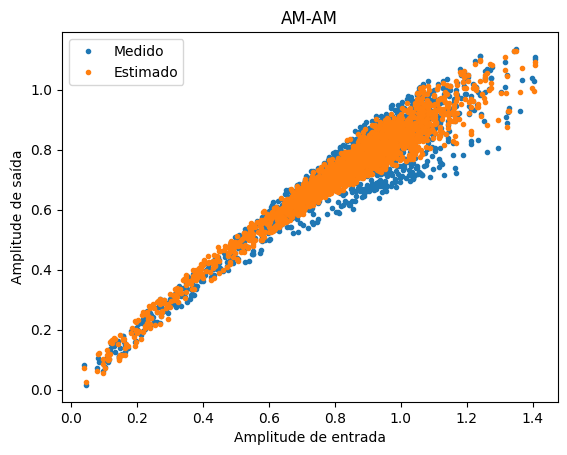

In [8]:
import matplotlib.pyplot as plt
nmse_calculo = lambda predicted_val, data_out, M:10 * np.log10(np.mean(np.abs(data_out[M:] - predicted_val) ** 2) / np.mean(np.abs(data_out[M:]) ** 2))

def mp(P, M, xn, coef):
    L = xn.shape[0]
    y_est = np.zeros(L, dtype=complex)

    idx = 0
    for k in range(M+1):
        xk = np.roll(xn, k)
        for p in range(1, P+1):
            y_est += coef[idx] * (xk * np.abs(xk)**((p-1)*2))
            idx += 1
    return y_est


predicted_val = mp(ordem, memoria, in_data_val, coef_otimo)

nmse_calculado = nmse_calculo(predicted_val[memoria:], out_data_val, memoria)
print(f"valor de NMSE: {nmse_calculado}")
plt.figure()
plt.plot(np.abs(in_data_val[memoria:]), np.abs(out_data_val[memoria:]), '.', label='Medido')
plt.plot(np.abs(in_data_val[memoria:]), np.abs(predicted_val[memoria:]), '.', label='Estimado')
plt.xlabel('Amplitude de entrada')
plt.ylabel('Amplitude de saída')
plt.title('AM-AM')
plt.legend()

plt.show()